In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import integration as ig
import coordinates as coords
from matplotlib import interactive
interactive(True)
from sympy import symbols
from IPython.display import display
sy.init_printing(use_latex="png",scale=2)

# Definitions of: $t,r_s,x_1=r,x_2=\phi,\vec{x},\vec{v}$
The time $t$ is measured in units of $c$ for the analytic derivation

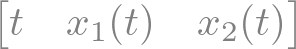

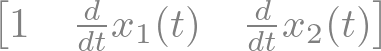

In [2]:
t,rs = symbols('t,r_s',real=True)
#x1 = sy.Function("x_1",real=True)(t)
x1 = sy.Function("x_1",real=True)(t)
x2 = sy.Function("x_2",real=True)(t)
x = sy.Array([t,x1,x2])
vx1 = sy.Derivative(x1,t)
vx2 = sy.Derivative(x2,t)
v = sy.Array([1,vx1,vx2])
display(x)
display(v)

# Definition of the Schwarzschild metric tensor $g_{\mu \nu}$
see https://en.wikipedia.org/wiki/Schwarzschild_metric#Formulation

Here the $g_{33}$ should be $-r^2$ but this does not produce the expected output, while $g_{33}=1$ does.
Why?????

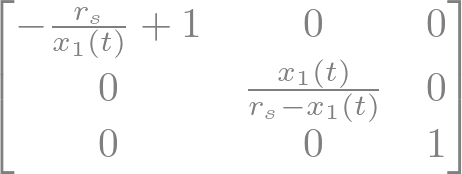

In [3]:
g = sy.Matrix([[(1-rs/x1),0,0],[0,-1/(1-rs/x1),0],[0,0,1]])
g = sy.simplify(g)
ndims = g.rows
display(g)

# Inverse metric tensor $g^{\mu \nu}$

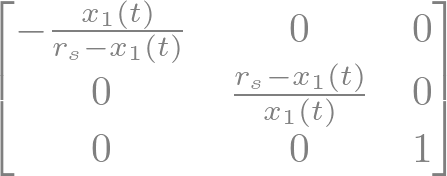

In [4]:
gi = g.inv()
#gi = sy.simplify(gi)
display(gi)

# Calculation of the Christoffel symbols $\Gamma^{i}{}_{kl}$
see https://en.wikipedia.org/wiki/Christoffel_symbols#Christoffel_symbols_of_the_second_kind_(symmetric_definition)

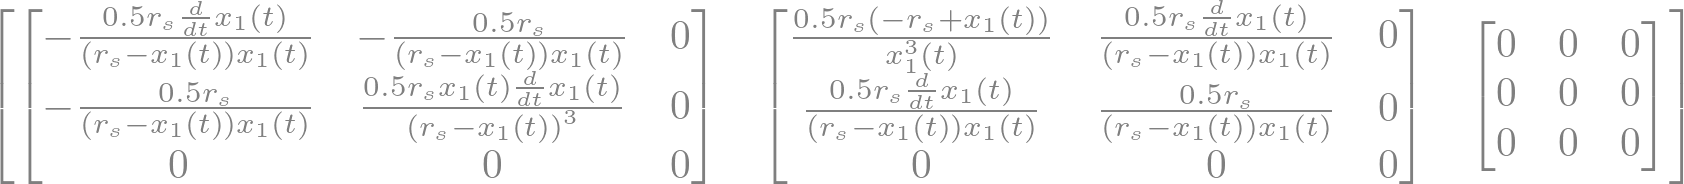

In [5]:
gamma = sy.MutableDenseNDimArray(np.zeros((ndims,ndims,ndims),dtype=int))
for i in range(ndims):
    for k in range(ndims):
        for l in range(ndims):
            for m in range(ndims):
                gamma[i,k,l] += 1/2*gi[i,m]*(sy.diff(g[m,k],x[l]) + sy.diff(g[m,l],x[k]) - sy.diff(g[k,l],x[m]))
gamma = sy.simplify(gamma)
display(gamma)

# Calculation of the acceleration $\frac{\mathrm{d}^2 x^{\nu}}{\mathrm{d}t^2}$
see https://en.wikipedia.org/wiki/Geodesics_in_general_relativity#Equivalent_mathematical_expression_using_coordinate_time_as_parameter
(here $t$ is still in units of $c$)

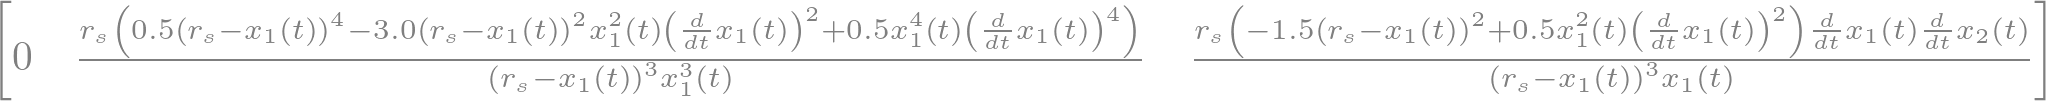

In [6]:
acc = sy.MutableDenseNDimArray(np.zeros((ndims),dtype=int))
for beta in range(ndims):
    for alpha in range(ndims):
        for nu in range(ndims):
            acc[nu] += -gamma[nu,alpha,beta]*v[alpha]*v[beta] + gamma[0,alpha,beta]*v[alpha]*v[beta]*v[nu]
acc = sy.simplify(acc)
display(acc)

# Simple Example for $\phi = 0$, $\vec{v} = 0$

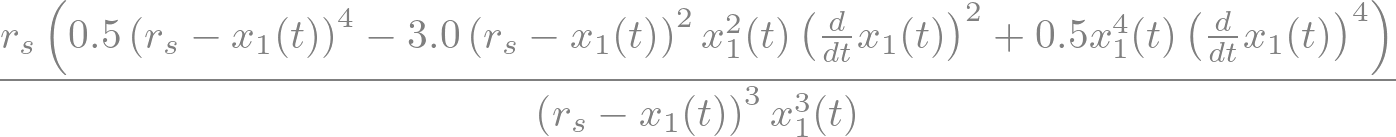

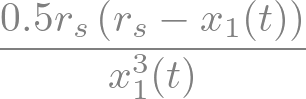

In [7]:
accR_simp = sy.simplify(acc[1].subs(x2,0))
display(accR_simp)
accR_simp = sy.simplify(accR_simp.subs(vx1,0))
display(accR_simp)

### In this case: $\frac{\partial^2 r}{\partial (ct)^2} = \frac{r_s (r_s - r)}{2 r^3}$
### With $r_s = \frac{2 G M}{c^2}$ being the Schwarzschild radius
### For $c \rightarrow \infty$ it follows: $\frac{\partial^2 r}{\partial t^2} = - \frac{G M}{r^2} + \frac{2 G^2 M^2}{c^2 r^3} + \mathcal{O}(c^{-3})$
### This corresponds to newtons law of gravitation.

# Setting the constants $G M$, $c$ and calculating $r_s$

In [8]:
GM_val = 1
c_val = 3
rs_val = 2*GM_val/c_val**2

# Transformation into cartesian coordinates
also the acceleration for newtonian gravity is defined, to make comparisons.

In [9]:
accx1 = sy.lambdify([x1,x2,vx1,vx2,rs],acc[1])
accx2 = sy.lambdify([x1,x2,vx1,vx2,rs],acc[2])
def accF(x,y,vx,vy):
    # calculate polar coordinates
    r,phi,_ = coords.conv_coords([x,y,0], "cartesian", "cylindrical")
    
    # check is trajectory is outside of the event horizon
    if r < rs_val:
        return (0,0)
    
    # rescale v with c, since time is measured in units of c (and vx, vy are not measured in units of c)
    vr,vphi,_ = coords.conv_vec([x,y,0], [vx/c_val,vy/c_val,0], "cartesian", "cylindrical")
    
    # calculate acceleration in r and phi direction (rescale vphi with 1/r, since x2 = phi and not phi*r, also rescale accx2 by r)
    accr,accphi = accx1(r,phi,vr,vphi/r,rs_val)*c_val**2,r*accx2(r,phi,vr,vphi/r,rs_val)*c_val**2
    
    # converte to cartesian coordinates
    accx,accy,_ = coords.conv_vec([r,phi,0], [accr,accphi,0], "cylindrical", "cartesian")
    
    return (accx,accy)
def accF_gravity(x,y,vx,vy):
    r = np.sqrt(x**2+y**2)
    return (-GM_val*x/r**3,-GM_val*y/r**3)

# Plot the quotient of the schwarzschild and newtonian acceleration

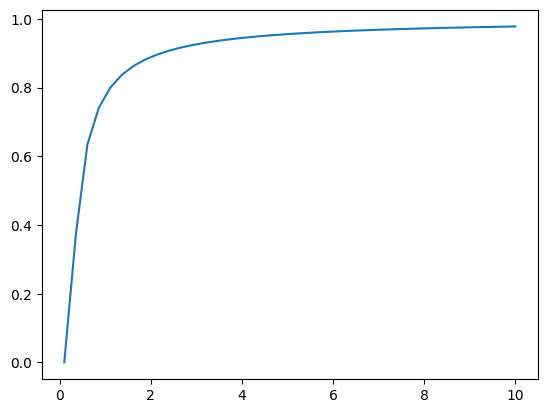

In [10]:
%matplotlib inline
testRs = np.linspace(0.1,10,40)
rel = []
for x in testRs:
    rel.append(accF(x,0,0,0)[0]/accF_gravity(x,0,0,0)[0])
plt.plot(testRs,rel)
plt.show()

# Calculate some geodesics

In [275]:
starts = []

y0s = np.array([19.75,17.0715,15.045,12.05,8.715,8.415,8.1,7.78,7.454545])
precessions = np.array([68,50,38,23,10,9,8,7,6])
precession_idx = 6

#starts.append([0,y0s[precession_idx],-0.2,0.0])

starts.append([0,rs_val*1.1,-0.99*c_val,0.0])

trajectories = []
for start in starts:
    ts, infos = ig.get_geodesic(start[0],start[1],start[2],start[3],accF,dt=0.0004,N=10000,bounds=[-20,-20,20,20],eps=4e-5,minNdiff=100)
    trajectories.append(infos[:2])

# Plot the geodesics

/tmp/ipykernel_20756/3932702203.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


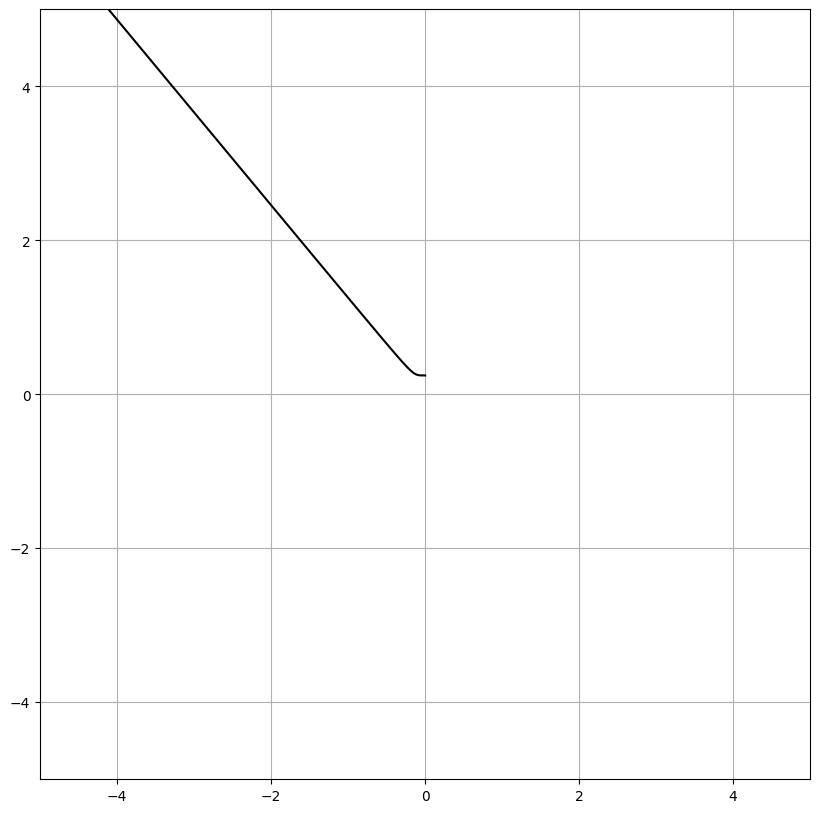

In [276]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_aspect(1.0)
for p in trajectories[1:]:
    ax.plot(p[0],p[1])#,marker="x")
ax.plot(trajectories[0][0][:],trajectories[0][1][:],color="k")
#ax.plot(trajectories[0][0][:ti],trajectories[0][1][:ti],color="grey")
vsize = 5
ax.set_xlim(-vsize,vsize)
ax.set_ylim(-vsize,vsize)
#ax.set_xlim(-20,-12)
#ax.set_ylim(-4,4)
ax.grid()
fig.show()

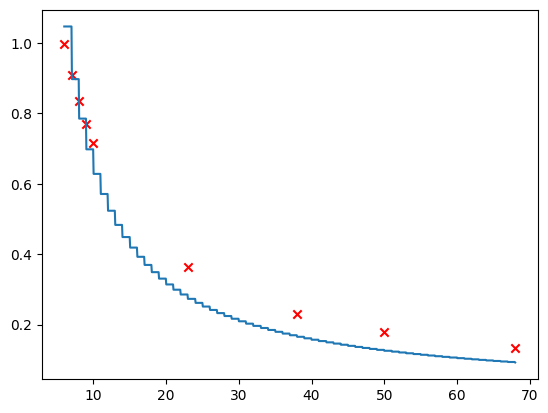

In [237]:
dphis_r = 2*np.pi/precessions
dphis_m = np.array([0.133414,0.179103,0.231457, 0.364446, 0.715223, 0.770252, 0.835401, 0.910442, 0.998089])


plt.scatter(precessions, dphis_m, marker="x",color="red")
plt.plot(np.linspace(precessions[0],precessions[-1],1000), 2*np.pi/np.linspace(precessions[0],precessions[-1],1000).astype(int))
plt.show()

r_a = 8.1
r_b = 1.4830368034957198
dphi_theory = 0.835401
dphi = 0.785398
periods = 8


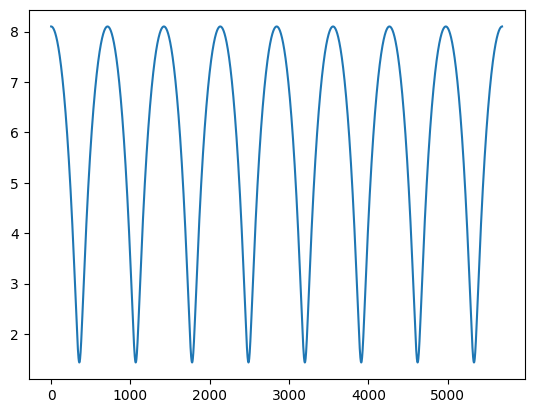

In [238]:
ti = np.argwhere(trajectories[0][1]<0)[0,0]
ti = np.argwhere(trajectories[0][1][ti:]>0)[0,0]+ti
r_a = np.max(trajectories[0][1][:ti])
r_b = np.abs(np.min(trajectories[0][1][:ti]))
e = (r_a-r_b)/(r_a+r_b)
A = (r_a+r_b)/2
print(f"r_a = {r_a}")
print(f"r_b = {r_b}")
dphis_m[precession_idx] = 3*np.pi*rs_val*(r_a+r_b)/(2*r_a*r_b)
print(f"dphi_theory = {3*np.pi*rs_val*(r_a+r_b)/(2*r_a*r_b):0.6f}")
print(f"dphi = {2*np.pi/precessions[precession_idx]:0.6f}")
rs = np.sqrt(trajectories[0][0]**2 + trajectories[0][1]**2)
mins = np.count_nonzero(np.logical_and(rs[:-2]>rs[1:-1], rs[1:-1]<rs[2:]))
print(f"periods = {mins}")
plt.plot(rs)
plt.show()